<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/Food_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
drive.mount('/content/drive')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda


train, test 데이터 구분


In [40]:
validation_split = .2
batch_size = 32
LR = 1e-3
model_type = "ResNet18_Custom"
criterion = nn.CrossEntropyLoss()
new_model_train = True
shuffle_dataset = True
random_seed= 42

path = "/content/drive/MyDrive/AIIA AFAC/Original_Food_10"

In [41]:
# 데이터 변환 (Data Augmentation 추가)
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # 랜덤 크롭 & 리사이즈
        transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우반전
        transforms.RandomVerticalFlip(p=0.3),  # 30% 확률로 상하반전
        transforms.RandomRotation(degrees=30),  # -30도 ~ +30도 회전
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),  # 색상 변화
        transforms.RandomGrayscale(p=0.2),  # 20% 확률로 흑백 변환
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # 이동 & 크기 변형
        transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # 원근 왜곡
        transforms.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # 일부 영역 삭제
        transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # 블러 적용
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),  # 자동 데이터 증강
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
    ]),

    "test": transforms.Compose([
        transforms.Resize((224, 224)),  # 크기만 조정
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# 데이터셋 로드
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])

# 클래스 확인
class_names = image_datasets.classes


In [42]:
from torch.utils.data import random_split, DataLoader
import numpy as np
dataset_size = len(image_datasets)
test_split = 0.1  # 테스트 데이터 비율 (10%)
val_split = 0.2   # 검증 데이터 비율 (20%)

# 개수 계산
test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size  # 나머지는 학습 데이터

# 데이터 분할
train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])

# 검증 & 테스트 데이터에는 augmentation을 적용하지 않도록 transform 수정
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로딩 확인
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)


Train Batch Labels: tensor([2, 7, 8, 1, 7, 6, 0, 4, 2, 3, 5, 1, 3, 8, 6, 0, 4, 8, 2, 4, 8, 4, 4, 0,
        2, 8, 4, 6, 5, 7, 6, 1])


In [43]:
from collections import Counter

# 각 Subset에서 원본 데이터셋의 레이블 가져오기
train_labels = [image_datasets.targets[i] for i in train_dataset.indices]
val_labels = [image_datasets.targets[i] for i in val_dataset.indices]
tset_labels = [image_datasets.targets[i] for i in test_dataset.indices]

# 분포 확인
print("Train Label Distribution:", Counter(train_labels))
print("Validation Label Distribution:", Counter(val_labels))
print("Validation Label Distribution:", Counter(tset_labels))

Train Label Distribution: Counter({1: 722, 5: 712, 8: 708, 6: 706, 3: 700, 0: 699, 4: 694, 7: 687, 2: 676, 9: 18})
Validation Label Distribution: Counter({2: 224, 3: 209, 7: 205, 6: 201, 4: 198, 8: 198, 0: 195, 1: 190, 5: 176, 9: 9})
Validation Label Distribution: Counter({5: 112, 4: 108, 7: 108, 0: 106, 2: 100, 8: 93, 6: 93, 3: 91, 1: 88, 9: 3})


tensor([0, 0, 3, 8, 5, 4, 1, 6, 4, 7, 1, 0, 0, 2, 0, 2, 4, 8, 0, 5, 5, 3, 1, 4,
        8, 8, 4, 2, 3, 5, 2, 3])


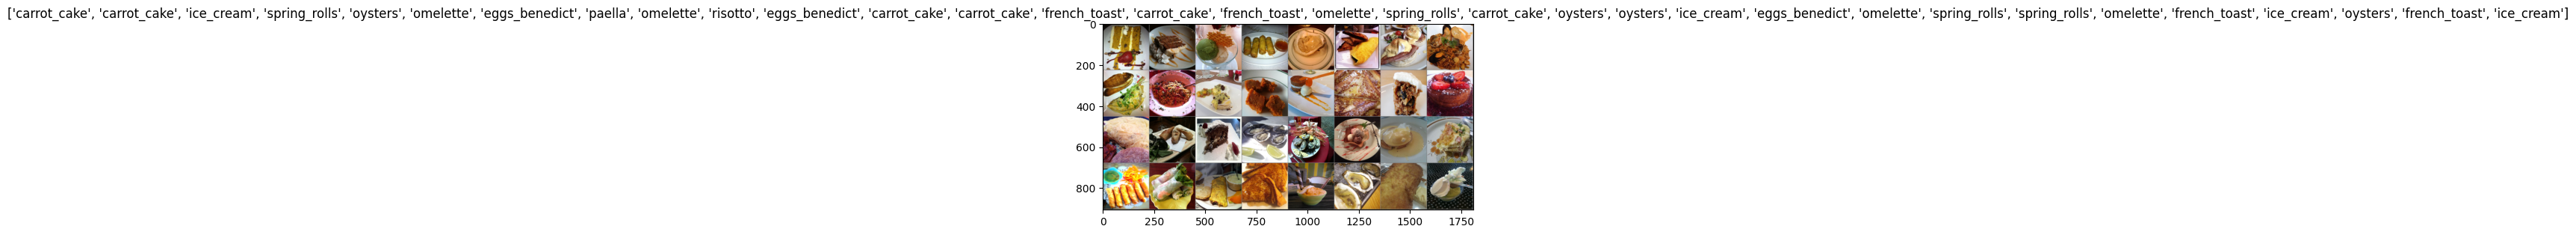

In [44]:
inputs, classes = next(iter(train_loader))
print(classes)
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [45]:
class ResNet18_Custom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18_Custom, self).__init__()

        # ResNet-18 모델을 불러오되, 기본 학습된 가중치는 불러오지 않음
        self.resnet = models.resnet18(pretrained=False)

        # 마지막 Fully Connected 레이어를 원하는 클래스 개수로 수정
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        # ResNet의 기본 흐름을 그대로 따라감
        x = self.resnet(x)
        return x

# 모델 불러오기
model = ResNet18_Custom(num_classes=len(class_names))  # 데이터셋 클래스 개수에 맞게 설정
model = model.to(DEVICE)  # 모델을 GPU/CPU로 이동


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [46]:

# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)


In [47]:
# 모델 저장 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f" 모델 저장 완료: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)  # ✅ GPU or CPU 자동 설정
    model.load_state_dict(state_dict)
    model = model.to(device)  # ✅ 모델도 GPU로 이동
    print(f"🔹 Model loaded from {path} to {device}")
    return model

In [49]:
# Early Stopping 설정
num_epochs = 30
patience = 5  # 검증 손실이 개선되지 않아도 몇 epoch까지 기다릴지
best_loss = float("inf")  # 최소 Validation Loss 저장
counter = 0  # Early Stopping 체크용 카운터

# 학습 기록 저장용
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# 체크포인트 저장 경로
checkpoint_path = "checkpoint.pth"

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # 검증 루프 (Validation Loss & Accuracy 계산)
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 학습 기록 저장
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    # Early Stopping 체크
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        counter = 0  # 개선되었으므로 counter 초기화
        # 체크포인트 저장
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch+1}, loss: {avg_val_loss:.4f}")
    else:
        counter += 1  # 개선되지 않았으므로 counter 증가
        print(f"⚠️ Early Stopping Counter: {counter}/{patience}")

    # patience 이상으로 개선이 없으면 학습 중단
    if counter >= patience:
        print("⛔ Early stopping triggered! Training stopped.")
        break

# 체크포인트에서 최적 모델 불러오기
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")


Epoch 1/30: 100%|██████████| 198/198 [01:07<00:00,  2.93it/s, loss=1.2]


Epoch 1/30, Train Loss: 1.6326, Train Acc: 0.4288, Val Loss: 1.9348, Val Acc: 0.3584
✅ Checkpoint saved at epoch 1, loss: 1.9348


Epoch 2/30: 100%|██████████| 198/198 [01:06<00:00,  3.00it/s, loss=1.3]


Epoch 2/30, Train Loss: 1.5066, Train Acc: 0.4750, Val Loss: 1.5479, Val Acc: 0.4753
✅ Checkpoint saved at epoch 2, loss: 1.5479


Epoch 3/30: 100%|██████████| 198/198 [01:05<00:00,  3.01it/s, loss=1.74]


Epoch 3/30, Train Loss: 1.4061, Train Acc: 0.5174, Val Loss: 1.4929, Val Acc: 0.4881
✅ Checkpoint saved at epoch 3, loss: 1.4929


Epoch 4/30: 100%|██████████| 198/198 [01:05<00:00,  3.02it/s, loss=1.42]


Epoch 4/30, Train Loss: 1.3060, Train Acc: 0.5512, Val Loss: 1.6317, Val Acc: 0.4587
⚠️ Early Stopping Counter: 1/5


Epoch 5/30: 100%|██████████| 198/198 [01:05<00:00,  3.02it/s, loss=1.22]


Epoch 5/30, Train Loss: 1.2006, Train Acc: 0.5938, Val Loss: 1.4630, Val Acc: 0.5252
✅ Checkpoint saved at epoch 5, loss: 1.4630


Epoch 6/30: 100%|██████████| 198/198 [01:05<00:00,  3.02it/s, loss=1.52]


Epoch 6/30, Train Loss: 1.1253, Train Acc: 0.6239, Val Loss: 2.1587, Val Acc: 0.3856
⚠️ Early Stopping Counter: 1/5


Epoch 7/30: 100%|██████████| 198/198 [01:05<00:00,  3.03it/s, loss=1.61]


Epoch 7/30, Train Loss: 1.0779, Train Acc: 0.6376, Val Loss: 1.5916, Val Acc: 0.5069
⚠️ Early Stopping Counter: 2/5


Epoch 8/30: 100%|██████████| 198/198 [01:05<00:00,  3.04it/s, loss=1.24]


Epoch 8/30, Train Loss: 0.9981, Train Acc: 0.6588, Val Loss: 1.4839, Val Acc: 0.5363
⚠️ Early Stopping Counter: 3/5


Epoch 9/30: 100%|██████████| 198/198 [01:04<00:00,  3.05it/s, loss=1.16]


Epoch 9/30, Train Loss: 0.9152, Train Acc: 0.6884, Val Loss: 1.6449, Val Acc: 0.5003
⚠️ Early Stopping Counter: 4/5


Epoch 10/30: 100%|██████████| 198/198 [01:05<00:00,  3.04it/s, loss=1.69]


Epoch 10/30, Train Loss: 0.8159, Train Acc: 0.7254, Val Loss: 1.5325, Val Acc: 0.5396
⚠️ Early Stopping Counter: 5/5
⛔ Early stopping triggered! Training stopped.
✅ Model restored from checkpoint at epoch 5, loss: 1.4630


<ipython-input-49-347a27c72d41>:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


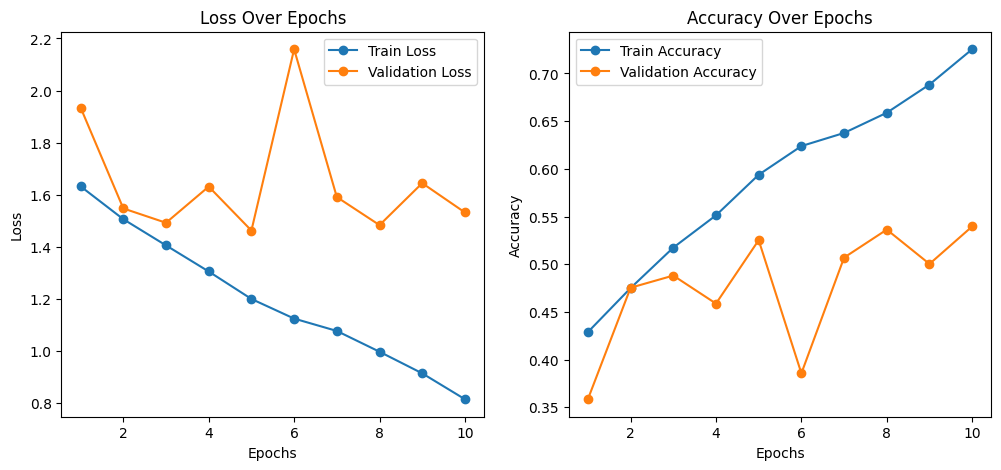

In [50]:
plot_training(history)

<ipython-input-51-b819c06ce8c0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model restored from checkpoint at epoch 5, loss: 1.4630
 Validation Loss: 1.4630, Accuracy: 52.52%
Final Validation Loss: 1.4630, Final Validation Accuracy: 52.5208


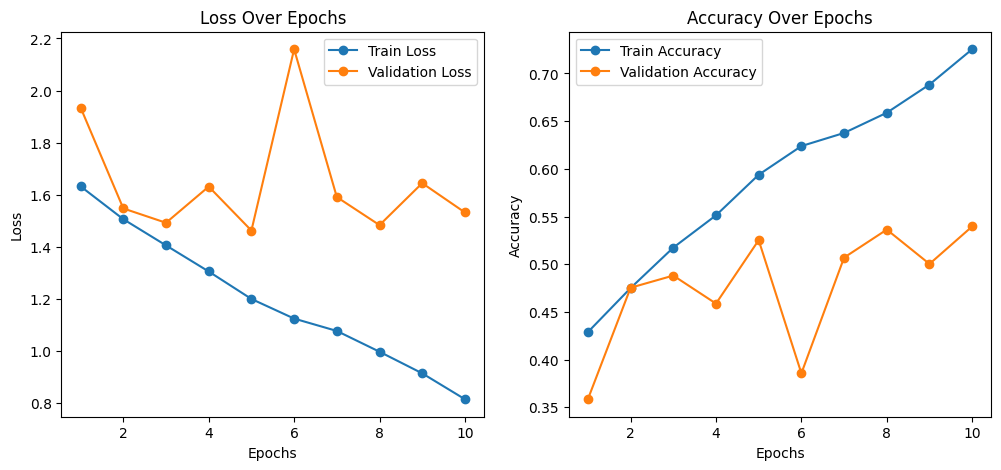

In [51]:
# 학습이 끝난 후, 가장 좋은 모델 불러오기
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")

# 학습 완료 후 최종 Validation 성능 확인
final_val_loss, final_val_acc = validate_model(model, validation_loader, DEVICE)
print(f"Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")

# 학습 과정 그래프 그리기 (필요한 경우)
plot_training(history)  # 학습 과정 시각화
